<h1><center>Gender Recognition Model Using Neural Networks</center></h1>

<h2><center>Authors:</center></h2>
<h3><center>Alen Adiyev, Zhamilya Saparova, Nuray Serkali</center></h3>

### 1. Goal: Build an effective ML model that predicts gender of a person based on the audio data's features using Neural Networks

import the modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext tensorboard


from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


### 2. Data Investigation

In [ ]:
df = pd.read_csv('voice.csv')
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [ ]:
df.tail()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female
3167,0.165509,0.092884,0.183044,0.070072,0.250827,0.180756,1.705029,5.769115,0.938829,0.601529,...,0.165509,0.185607,0.062257,0.271186,0.227022,0.007812,0.554688,0.546875,0.350000,female


In [ ]:
print("Number of features: {}".format(df.shape[1]-1))
print("Number of labels: {} -> {}".format(len(df.label.unique()), df.label.unique()))

Number of features: 20
Number of labels: 2 -> ['male' 'female']


In [ ]:
print("# Total voices: {}".format(df.shape[0]))
print("# Male voices: {}".format(df[df.label == 'male'].shape[0]),"- {}% of the dataset".format((df[df.label == 'male'].shape[0]/df.shape[0])*100))
print("# Female voices: {}".format(df[df.label == 'female'].shape[0]),"- {}% of the dataset".format((df[df.label == 'female'].shape[0]/df.shape[0])*100))

# Total voices: 3168
# Male voices: 1584 - 50.0% of the dataset
# Female voices: 1584 - 50.0% of the dataset


In [ ]:
if len(np.where(pd.isnull(df))[0]) > 0:
    print("There are empty cells")
else:
    print ("The dataset has no empty cells")

The dataset has no empty cells


### 3. Feature Selection & Data Preprocessing

Let's first change the labels: {male, female} -> {1, 0}

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:,-1].values

#Male = 1, Female = 0
gender_encoder = LabelEncoder()
y = gender_encoder.fit_transform(y) 

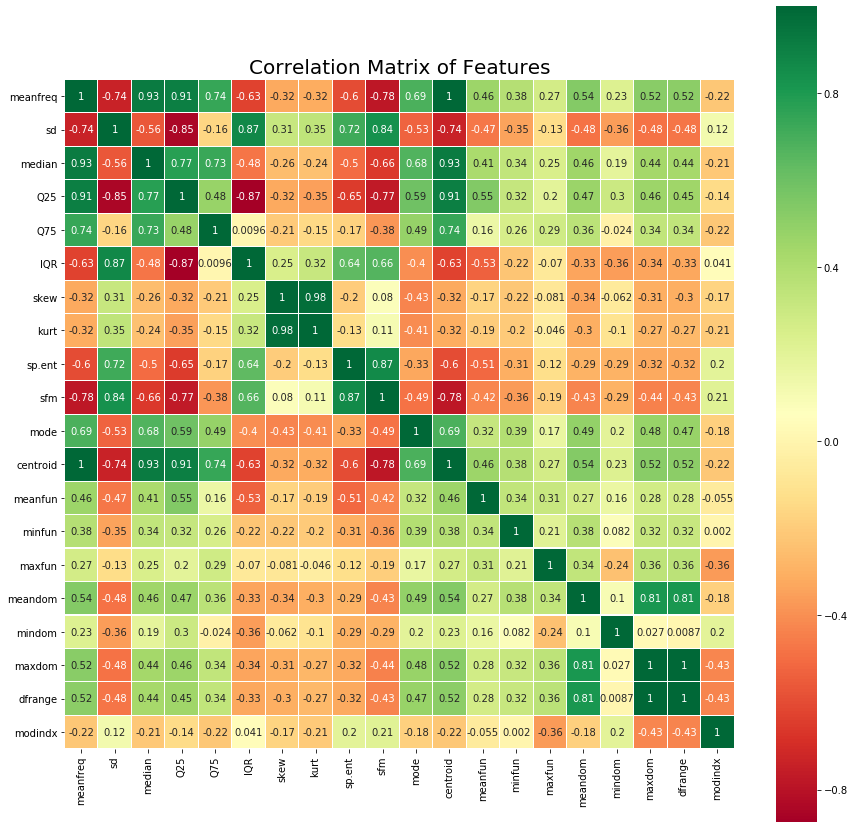

In [ ]:
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix of Features', size=20)
sns.heatmap(df.iloc[:, :-1].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap="RdYlGn", linecolor='white', annot=True)

Additionally, let us compare features based on their relationship with the labels

In [ ]:
X = df.iloc[:,0:20]  
y = df.iloc[:,-1] 

#apply SelectKBest to extract best features ranking
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(20,'Score'))  

       Specs         Score
7       kurt  11987.597926
17    maxdom    297.819019
18   dfrange    290.272018
15   meandom     38.460229
9        sfm     31.246850
5        IQR     26.337745
6       skew     24.329583
12   meanfun     16.094352
3        Q25     13.977196
16    mindom      9.162780
1         sd      3.535149
10      mode      3.369843
2     median      1.818288
0   meanfreq      1.783946
11  centroid      1.783946
8     sp.ent      1.722517
13    minfun      0.593977
14    maxfun      0.306703
19   modindx      0.246748
4        Q75      0.035247


From the above heatmap we can see strong correlations(0.95-1) between meanfreq-centroid (1), maxdom-dfrange (1), skew-kurt (0.98). This means that we can remove one of each pair without any loss of valuable data inforamtion. Let's remove centroid, dfrange, and skew.

Also, From the above table we can see what features contribute more to the output. Let us discard features that have score below 1 (i.e. minfun, maxfun, modindx,Q75)

In [ ]:
# Final dataset
df = df.drop(["minfun", "maxfun", "modindx", "Q75", "centroid", "dfrange", "skew"], axis=1)

Now, let's create features matrix and change the labels from {male, female} to {1, 0}

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:,-1].values

gender_encoder = LabelEncoder()
y = gender_encoder.fit_transform(y)

print("Final number of features is {}".format(len(X[0])))
print("Final number of samples is {}".format(len(y)))

Final number of features is 13
Final number of samples is 3168


Next, we need to normalize every feature in our dataset (X matrix of input features)

In [ ]:
norm = StandardScaler()
norm.fit(X)
X_norm = norm.transform(X)

# we will be using standard 10-Fold cross validation technique
x_train, x_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.1, random_state = 1)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# lists to store model's results
models_names = []
models_accuracies = []

### 4. Training and Testing with multiple models

> ### 4.1 Linear Regression

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # Using the Linear Regression from Scikit-Learn
    from sklearn.linear_model import LinearRegression
    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    y_pred = lin_reg.predict(x_test)
    # Test Accuracy (logistic regression)
    print("Linear Regression test accuracy : {} %.".format(1 - np.mean(np.abs(y_pred - y_test))))
    # report performance
    scores = cross_val_score(lin_reg, X_norm, y, scoring='r2', cv=cv)
    print('Linear Regression 10-Fold CV Accuracy: %.4f (std = %.4f)' % (scores.mean(), scores.std()))
    models_names.append("Linear Reg.")
    models_accuracies.append(scores.mean())

Linear Regression test accuracy : 0.83779690060814 %.
Linear Regression 10-Fold CV Accuracy: 0.7889 (std = 0.0207)


> ### 4.2 Logistic Regression

In [ ]:
# Using the Logistic Regression from Scikit-Learn
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(x_train,y_train) 

# report performance
scores = cross_val_score(log_reg, X_norm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Logistic Regression Classification 10-Fold CV Accuracy: %.4f (std = %.4f)' % (scores.mean(), scores.std()))
models_names.append("Logistic Reg.")
models_accuracies.append(scores.mean())

Logistic Regression Classification 10-Fold CV Accuracy: 0.9710 (std = 0.0077)


> ### 4.3 Support Vector Machine (SVM)

In [ ]:
#importing support vector classifyer
from sklearn.svm import SVC
svm = SVC(random_state=20, gamma="auto")
svm.fit(x_train,y_train)

# report performance
scores = cross_val_score(svm, X_norm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM Classification 10-Fold CV Accuracy: %.4f - (std = %.4f)' % (scores.mean(), scores.std()))
models_names.append("SVM.")
models_accuracies.append(scores.mean())

SVM Classification 10-Fold CV Accuracy: 0.9785 - (std = 0.0083)


> ### 4.4 Random Forest

In [ ]:
# Using Random FOrest from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier(n_estimators=100, random_state=20)
rand_forest.fit(x_train,y_train)

# report performance
scores = cross_val_score(rand_forest, X_norm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Random Forest Classification 10-Fold CV Accuracy: %.4f (std = %.4f)' % (scores.mean(), scores.std()))
models_names.append("Random Forest")
models_accuracies.append(scores.mean())

Random Forest Classification 10-Fold CV Accuracy: 0.9808 (std = 0.0086)


> ### 4.5 Deep Neural Networks (DNN)

For our training we first need to split the dataset into train and validation sets

In [ ]:
y_train_nn = to_categorical(y_train, 2)
y_test_nn = to_categorical(y_test, 2)

In [ ]:
#let's create a sequential model with 4 hidden dense layers and ReLU activation function.

model = Sequential()

model.add(Dense(1700, activation='relu', input_dim = x_train.shape[1]))
model.add(Dense(1700, activation='relu'))
model.add(Dense(1700, activation='relu'))
model.add(Dense(1700, activation='relu'))

# sigmoid activation function for the output layer
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# use tensorboard to view metrics
tensorboard = TensorBoard()
# define early stopping to stop training after 10 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=10, restore_best_weights=True)

epochs = 50
# train the model using the training set and validating using validation set
model.fit(x_train, y_train_nn, epochs=epochs, validation_split = .1,callbacks=[tensorboard, early_stopping])

Epoch 1/50
 1/81 [..............................] - ETA: 0s - loss: 0.6897 - accuracy: 0.6875WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
81/81 [==============================] - 6s 71ms/step - loss: 0.1471 - accuracy: 0.9497 - val_loss: 0.0713 - val_accuracy: 0.9755
Epoch 2/50
81/81 [==============================] - 5s 66ms/step - loss: 0.0863 - accuracy: 0.9719 - val_loss: 0.1145 - val_accuracy: 0.9615
Epoch 3/50
81/81 [==============================] - 6s 76ms/step - loss: 0.0724 - accuracy: 0.9747 - val_loss: 0.0772 - val_accuracy: 0.9720
Epoch 4/50
81/81 [==============================] - 7s 88ms/step - loss: 0.0715 - accuracy: 0.9727 - val_loss: 0.0648 - val_accuracy: 0.9790
Epoch 5/50
81/81 [==============================] - 7s 86ms/step - loss:

In [ ]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(x_test)} samples...")
loss, accuracy = model.evaluate(x_test, y_test_nn, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
models_names.append("DNN")
models_accuracies.append(accuracy)

Evaluating the model using 317 samples...
Loss: 0.0139
Accuracy: 0.9968


In [ ]:
%tensorboard --logdir="logs"

Reusing TensorBoard on port 6007 (pid 9488), started 9:56:41 ago. (Use '!kill 9488' to kill it.)

### 5. Results Visualization

Now, let us compare models' accuracy side-by-side using different visualization tools (bar graphs, confusion matrices)

Text(0, 0.5, 'Accuracy')

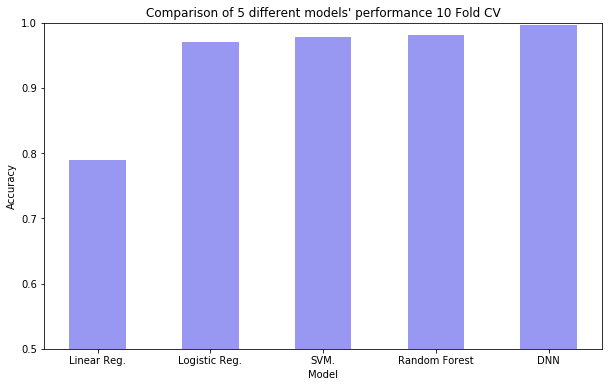

In [ ]:
# bar graph with accuracy results for 5 models
plt.figure(figsize=(10,6))
plt.ylim([0.5,1])
plt.bar(models_names,models_accuracies,width=0.5, color=(0.2, 0.2, 0.9, 0.5))
plt.title("Comparison of 5 different models' performance 10 Fold CV")
plt.xlabel("Model")
plt.ylabel("Accuracy")

Logistic Regression


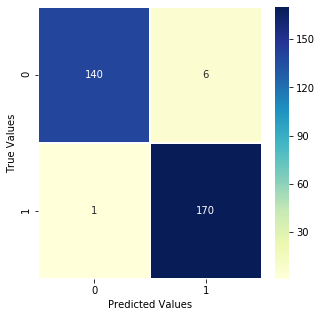

SVM


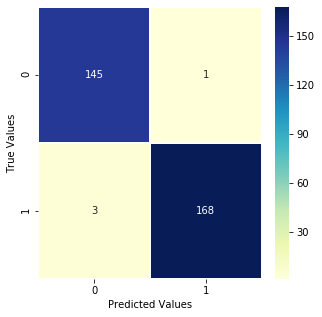

Random Forest


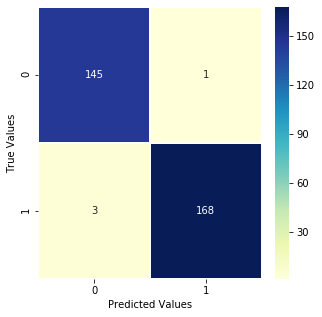

DNN


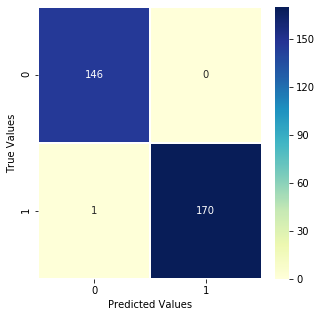

In [ ]:
#Confusion Matrices

print('Logistic Regression')
y_pred = log_reg.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,cmap="YlGnBu",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

print('SVM')
y_pred = svm.predict(x_test)
conf_mat_1 = confusion_matrix(y_test,y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_1,annot=True,linewidths=0.5,cmap="YlGnBu",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

print('Random Forest')
y_pred = rand_forest.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,cmap="YlGnBu",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

print('DNN')
y_pred = model.predict(x_test)
y_pred_new = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if y_pred[i][0]>y_pred[i][1]:
        y_pred_new[i] = 0
    else:
        y_pred_new[i] = 1
conf_mat = confusion_matrix(y_test, y_pred_new)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,cmap="YlGnBu",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()